In [47]:
import pathlib

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import openep
from openep._datasets.openep_datasets import DATASET_2

In [2]:
# Set the backend used for plotting
import pyvista
pyvista.set_jupyter_backend('ipygany')

# Load a case
We will load a `.mat` file that was created using OpenEP-MATLAB and then take a look at the data stored in the case

In [3]:
case = openep.load_openep_mat(DATASET_2)


Note, `DATASET_2` is simply a path to a `.mat` file

In [4]:
print(DATASET_2)

c:\Anaconda3\envs\openep-tutorials\lib\site-packages\openep\_datasets\OpenEP-MATLAB\openep_dataset_2.mat


### Look at the surface data


In [5]:
print(case)  # The surface mesh has 14383 nodes, 16942 triangles

openep_dataset_2.mat( nodes: (14383, 3) indices: (16942, 3) fields: ('bipolar_voltage', 'unipolar_voltage', 'local_activation_time', 'impedance', 'force', 'thickness', 'cell_region', 'longitudinal_fibres', 'transverse_fibres', 'pacing_site') )


The nodes and triangle data of the surface mesh are stored in `case.points` and `case.indices` respectively

In [6]:
case.points  # the x, y, z coordinate of each node in the surface mesh

array([[ 46.451, -98.879, 155.286],
       [ 38.777, -94.997, 121.448],
       [ 37.268, -69.189, 141.284],
       ...,
       [-62.585, -77.163, 133.982],
       [-63.766, -76.47 , 119.425],
       [-64.5  , -75.396, 119.241]])

In [7]:
case.indices  # the indices of nodes in each triangle

array([[ 5343,  7474,  7523],
       [ 7976,  4159,  4138],
       [ 7953,  5780, 12295],
       ...,
       [10283, 10270, 14360],
       [10283, 14360, 14361],
       [14380,  6871, 14364]])

Scalar data associated with the mesh are stored in `case.fields`

In [8]:
case.fields

fields: ('bipolar_voltage', 'unipolar_voltage', 'local_activation_time', 'impedance', 'force', 'thickness', 'cell_region', 'longitudinal_fibres', 'transverse_fibres', 'pacing_site')

In [9]:
case.fields.bipolar_voltage

array([    nan, 1.07604, 1.71656, ..., 0.32316, 0.16372, 0.19536])

### Visualising the surface mesh

In [10]:
mesh = case.create_mesh()  # creates a pyvista.PolyData mesh from case.points and case.indices

In [11]:
mesh

PolyData,Information
N Cells,16942
N Points,14383
X Bounds,"-7.584e+01, 6.374e+01"
Y Bounds,"-1.300e+02, -3.585e+01"
Z Bounds,"7.937e+01, 1.712e+02"
N Arrays,0


In [12]:
plotter = openep.draw.draw_map(
    mesh=mesh,
    field=case.fields.bipolar_voltage,
    add_mesh_kws=dict(cmap='Turbo'),
)  # creates a pyvista.Plotter


In [13]:
plotter.show()

c:\Anaconda3\envs\openep-tutorials\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


AppLayout(children=(VBox(children=(HTML(value='<h3></h3>'), Dropdown(description='Colormap:', options={'BrBG':…

### Electrical data
The bipolar electrograms, unipolar electrograms, reference electrograms, and ecgs are all stored in `case.electric`

In [14]:
case.electric  # we see there are 800 mapping points in this case

Electric data for 800 mapping points.

In [15]:
case.electric.bipolar_egm  # this is an Electrogram object, containing information about bipolar egms

Electrograms with 800 mapping points.

In [27]:
case.electric.bipolar_egm.egm  # the signals, shape (n_points, n_samples)

array([[ 0.018,  0.012, -0.006, ..., -0.015, -0.018, -0.27 ],
       [ 0.042,  0.036,  0.03 , ...,  0.006,  0.003, -0.165],
       [ 0.024,  0.018,  0.   , ...,  0.003,  0.015, -0.243],
       ...,
       [ 0.036,  0.033,  0.036, ...,  0.003,  0.   , -0.174],
       [ 0.003,  0.033,  0.039, ...,  0.   , -0.003, -0.12 ],
       [ 0.021,  0.009,  0.   , ..., -0.003,  0.018, -0.162]])

In [28]:
case.electric.bipolar_egm.points  # the x, y, z, coordinates of each mapping point

array([[ 35.4827, -71.0754, 137.582 ],
       [ 38.9305, -94.7062, 129.127 ],
       [ 24.7715, -70.5703, 121.098 ],
       ...,
       [-21.7413, -67.7685, 125.969 ],
       [-54.4597, -74.8781, 128.007 ],
       [-63.832 , -76.5177, 121.271 ]])

In [25]:
print(f'number of mapping points: {case.electric.bipolar_egm.n_points}')
print(f'number of samples: {case.electric.bipolar_egm.n_samples}')
print(f'first 5 electrode names: {case.electric.bipolar_egm.names[:5]}')
print(f'first 5 voltage values: {case.electric.bipolar_egm.voltage[:5]}')


number of mapping points: 800
number of samples: 2500
first 5 electrode names: ['20A_19-20' '20A_1-2' '20A_17-18' '20A_17-18' '20A_9-10']
first 5 voltage values: [0.651 0.45  1.542 0.513 0.315]


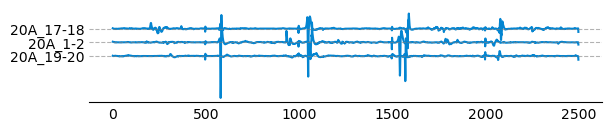

In [19]:
egm_figure, egm_axes = openep.draw.plot_electrograms(
    times=case.electric.times,
    electrograms=case.electric.bipolar_egm.egm[:3],  # plot the first 3 electrograms
    names=case.electric.bipolar_egm.names[:3],  # pass the first 3 electrode names
)  # creates a matplotlib.pyplot.Figure and matplotlib.pyplot.Axes


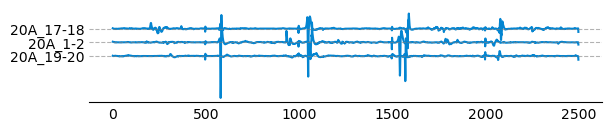

In [20]:
egm_figure

In [21]:
egm_axes

<AxesSubplot:>

### Interpolate electrical data onto the surface mesh
The bipolar voltage we visualised above (`case.fields.bipolar_voltage`) was calculated by CARTO and then exported from the mapping system.

However, it is not known what interpolation method is used by CARTO (or other system vendors) nor the interpolation parameters.

We can use OpenEP to re-interpolate electrical data onto the surface.

In [29]:
bipolar_voltage = openep.case.interpolate_voltage_onto_surface(case=case)

In [30]:
mesh.clear_data()
plotter = openep.draw.draw_map(
    mesh=mesh,
    field=case.fields.bipolar_voltage,
    add_mesh_kws=dict(cmap='Turbo'),
)
plotter.show()

c:\Anaconda3\envs\openep-tutorials\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


AppLayout(children=(VBox(children=(HTML(value='<h3></h3>'), Dropdown(description='Colormap:', options={'BrBG':…

In [31]:
mesh.clear_data()
plotter = openep.draw.draw_map(
    mesh=mesh,
    field=bipolar_voltage,
    add_mesh_kws=dict(cmap='Turbo'),
)
plotter.show()


AppLayout(children=(VBox(children=(HTML(value='<h3></h3>'), Dropdown(description='Colormap:', options={'BrBG':…

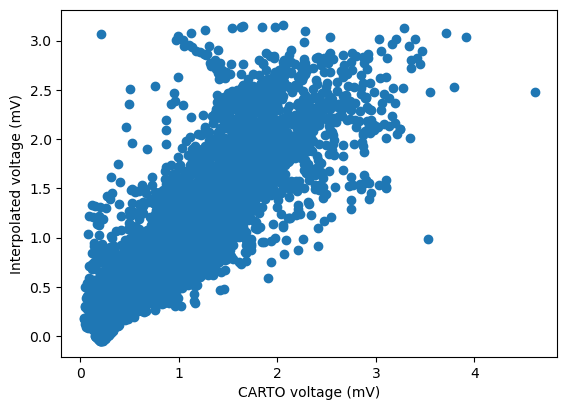

In [36]:
corr = plt.scatter(
    case.fields.bipolar_voltage,
    bipolar_voltage,
)
plt.xlabel('CARTO voltage (mV)')
plt.ylabel('Interpolated voltage (mV)')
corr.axes.set_aspect('equal')

Text(0, 0.5, 'Interpolated voltage (mV)')

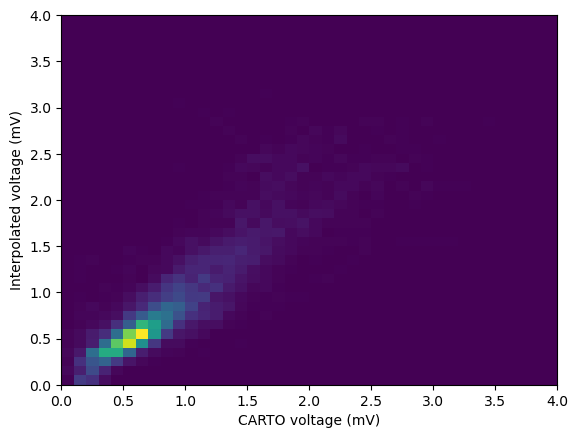

In [38]:
bins = np.linspace(0, 4, 41)
corr = plt.hist2d(
    x=case.fields.bipolar_voltage,
    y=bipolar_voltage,
    bins=bins,
)
plt.xlabel('CARTO voltage (mV)')
plt.ylabel('Interpolated voltage (mV)')


In [39]:
exclude = np.logical_or(
    np.isnan(bipolar_voltage),
    np.isnan(case.fields.bipolar_voltage),
)
r, p = scipy.stats.pearsonr(bipolar_voltage[~exclude], case.fields.bipolar_voltage[~exclude])

In [40]:
r  # Pearson correlation coefficient between CARTO voltages and interpolated voltages

0.868535653295952

## Load an openCARP dataset

In [41]:
case = openep.load_opencarp(
    points='C:/Users/Paul/Documents/software/development/openep-misc/examples/data/pig21_endo_coarse.pts',
    indices='C:/Users/Paul/Documents/software/development/openep-misc/examples/data/pig21_endo_coarse.elem',
    fibres=None,
    scale_points=1e-3,  # convert micrometres to mm
)


Currently, there is no electrical data in this case. We can add unipolar electrograms:

In [42]:
# First load the data with numpy
unipolar_egm = np.loadtxt('C:/Users/Paul/Documents/software/development/openep-misc/examples/data/pig21_endo_coarse_phie.dat')

# Add the egms to the case
case.add_unipolar_electrograms(
    unipolar=unipolar_egm,
    add_bipolar=True,  # also calculate bipolar egms from unipolar egms
)


### Visualise electrical on the surface mesh
We have loaded unipolar egms and determined bipolar egms from them. Now we can visualise this electrical data on the surface mesh.

In [43]:
bipolar_voltage = case.electric.bipolar_egm.voltage

In [45]:
mesh = case.create_mesh()
plotter = openep.draw.draw_map(
    mesh=mesh,
    field=bipolar_voltage,
    add_mesh_kws=dict(cmap='Turbo', clim=[0, 10]),  # set the min and max voltage to 0 and 10 mV respectively
)
plotter.show()


AppLayout(children=(VBox(children=(HTML(value='<h3></h3>'), Dropdown(description='Colormap:', options={'BrBG':…

# Load a CVI workspace and stack of DICOMS

In [54]:
data_directory = pathlib.Path('C:/Users/Paul/Documents/software/development/cvi42_to_mesh/cvi42_to_mesh/_datasets/')
cvi_workspace = data_directory / 'cvi42wsx_workspaces' / 'IHD001.cvi42wsx'
dicoms_directory = data_directory / 'dicoms' / 'IHD001'


In [61]:
epi_mesh, endo_mesh, dicoms_data = openep.load_circle_cvi(
    filename=cvi_workspace,
    dicoms_directory=dicoms_directory,
    return_dicoms_data=True,
)


In [62]:
dicoms_data

,slice_location,phase_encode,datetime,dicom_path,dicom_id,slice_thickness,basal_slice,pixel_spacing_x,pixel_spacing_y,upsample_factor
0,56,COL,20100927142817,C:/Users/Paul/Documents/software/development/c...,1.3.6.1.4.1.9590.100.1.2.172053503312281364121...,8.0,True,1.875,1.875,4
0,64,COL,20100927142817,C:/Users/Paul/Documents/software/development/c...,1.3.6.1.4.1.9590.100.1.2.327507644213058969518...,8.0,True,1.875,1.875,4
0,72,COL,20100927142822,C:/Users/Paul/Documents/software/development/c...,1.3.6.1.4.1.9590.100.1.2.318223274812269669624...,8.0,True,1.875,1.875,4
0,80,COL,20100927142822,C:/Users/Paul/Documents/software/development/c...,1.3.6.1.4.1.9590.100.1.2.158673170114156499083...,8.0,True,1.875,1.875,4
0,88,COL,20100927142827,C:/Users/Paul/Documents/software/development/c...,1.3.6.1.4.1.9590.100.1.2.187757150513143713742...,8.0,True,1.875,1.875,4
0,96,COL,20100927142827,C:/Users/Paul/Documents/software/development/c...,1.3.6.1.4.1.9590.100.1.2.344654518012187299908...,8.0,True,1.875,1.875,4
0,104,COL,20100927142832,C:/Users/Paul/Documents/software/development/c...,1.3.6.1.4.1.9590.100.1.2.184797745122824342103...,8.0,True,1.875,1.875,4
0,112,COL,20100927142832,C:/Users/Paul/Documents/software/development/c...,1.3.6.1.4.1.9590.100.1.2.294259932120461315333...,8.0,True,1.875,1.875,4
0,120,COL,20100927142837,C:/Users/Paul/Documents/software/development/c...,1.3.6.1.4.1.9590.100.1.2.240128468811107296042...,8.0,True,1.875,1.875,4
0,128,COL,20100927142837,C:/Users/Paul/Documents/software/development/c...,1.3.6.1.4.1.9590.100.1.2.387727528911111086018...,8.0,True,1.875,1.875,4


# Voxelise a surface mesh

In [74]:
case = openep.load_openep_mat(DATASET_2)
mesh = case.create_mesh()
voxel_grid = openep.mesh.voxelise(
    mesh=mesh,
    thickness=2,  # either a float or an array of floats (one per node in the mesh)
    edge_length=1.0,  # sets the resolution (mm) of the grid
)


In [75]:
plotter = pyvista.Plotter()
plotter.add_mesh(mesh, pickable=False)
plotter.add_mesh_clip_plane(
    voxel_grid,
    cmap='Greys',
    clim=[0, 1],
    interpolate_before_map=False,
    show_scalar_bar=False,
)
plotter.show()


c:\Anaconda3\envs\openep-tutorials\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


Scene(background_color='#4c4c4c', camera={'position': [119.9725943786629, 39.972594378662905, 264.972594378662…

### Extract the myocardium from the voxelised grid


In [77]:
voxel_grid = openep.mesh.voxelise(
    mesh=mesh,
    thickness=2,  # either a float or an array of floats (one per node in the mesh)
    edge_length=1.0,  # sets the resolution (mm) of the grid
    extract_myocardium=True,
)


In [78]:
voxel_grid.plot()

AppLayout(children=(VBox(children=(HTML(value='<h3>Filled</h3>'), Dropdown(description='Colormap:', options={'…